<a href="https://colab.research.google.com/github/bhargav23/EVA4/blob/master/S12/EVA_S12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA/S7')

In [0]:
#!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
#! git clone https://github.com/seshuad/IMagenet

In [0]:
#!unzip -q 'tiny-imagenet-200.zip'

In [0]:
import utils
from utils import load_training_images

In [0]:
BATCH_SIZE = 20
NUM_CLASSES = 200
NUM_IMAGES_PER_CLASS = 500
NUM_IMAGES = NUM_CLASSES * NUM_IMAGES_PER_CLASS
TRAINING_IMAGES_DIR = './tiny-imagenet-200/train/'
TRAIN_SIZE = NUM_IMAGES

NUM_VAL_IMAGES = 10000
VAL_IMAGES_DIR = './tiny-imagenet-200/val/'

IMAGE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_ARR_SIZE = IMAGE_SIZE * IMAGE_SIZE * NUM_CHANNELS
training_images, training_labels, training_files = load_training_images(TRAINING_IMAGES_DIR, batch_size=BATCH_SIZE)

In [0]:
import albumentations as A
from evaAlbumentations import AlbumentationTransforms
import numpy as np
import cv2
means = (0.49139968, 0.48215841, 0.44653091)
stdevs = (0.24703223, 0.24348513, 0.26158784)
train_transforms = AlbumentationTransforms(
    [ A.PadIfNeeded(40,40,border_mode=cv2.BORDER_CONSTANT, value=np.array(means)*255),
      A.RandomCrop(32, 32,  always_apply=True),
      A.HorizontalFlip(),
      A.Normalize(mean=means, std=stdevs),
      A.Cutout(num_holes=1, max_h_size=8, max_w_size=8, p=1)])



test_transforms = AlbumentationTransforms([A.Normalize(mean=means, std=stdevs)])

In [0]:
import evadata 
from evadata import TinyImagenetDataset
dataset, class_names = evadata.alldata('./tiny-imagenet-200/')
trainlen = int(len(dataset)*0.7)
train = TinyImagenetDataset(dataset[:trainlen], transform=train_transforms)
test = TinyImagenetDataset(dataset[trainlen:], transform=test_transforms)

In [0]:
import evadataloader
dataloader = evadataloader.DataLoader()

trainloader = dataloader.load(train)
testloader = dataloader.load(test)

Let us show some of the training images, for fun.



In [0]:
import evaresnet
from evaresnet import ResNet18


net = ResNet18(num_classes=len(class_names))

In [11]:
from torchsummary import summary
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


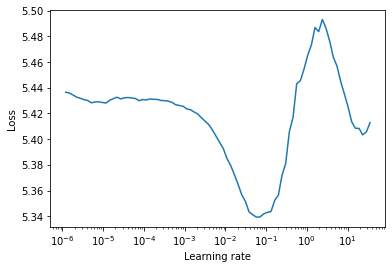

In [13]:
import sys
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100, step_mode="exp")
# Plot learning rate vs loss
lr_finder.plot()

# Reset graph
lr_finder.reset()

In [14]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
max_lr = lr[loss.index(min(loss))]
max_lr

0.05754399373371571

In [15]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from evascheduler import train,test
from torch.optim.lr_scheduler import OneCycleLR
L1lambda = 0
L2lambda = 0
EPOCHS = 50
model =  net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                 max_lr=0.03,
                 total_steps=51,
                 epochs=51,
                 pct_start=0.2,
                 cycle_momentum=False,
                 base_momentum=0.85,
                 max_momentum=0.95,
                 div_factor=10.,
                 final_div_factor=1e4,
                 last_epoch=-1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch,criterion)
    scheduler.step()
    test(model, device, testloader)


  0%|          | 0/151 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.8349409103393555 Batch_id=150 Accuracy=3.12: 100%|██████████| 151/151 [00:49<00:00,  3.08it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.9528, Accuracy: 1557/33000 (4.72%)

EPOCH: 1


Loss=4.342267036437988 Batch_id=150 Accuracy=6.95: 100%|██████████| 151/151 [00:49<00:00,  3.04it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.9448, Accuracy: 1823/33000 (5.52%)

EPOCH: 2


Loss=4.179075717926025 Batch_id=150 Accuracy=10.49: 100%|██████████| 151/151 [00:49<00:00,  3.06it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.9080, Accuracy: 3035/33000 (9.20%)

EPOCH: 3


  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8640, Accuracy: 4488/33000 (13.60%)

EPOCH: 4


Loss=3.8028130531311035 Batch_id=150 Accuracy=17.27: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8632, Accuracy: 4515/33000 (13.68%)

EPOCH: 5


Loss=3.7685739994049072 Batch_id=150 Accuracy=20.34: 100%|██████████| 151/151 [00:48<00:00,  3.10it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8320, Accuracy: 5545/33000 (16.80%)

EPOCH: 6


Loss=3.318566083908081 Batch_id=150 Accuracy=22.31: 100%|██████████| 151/151 [00:48<00:00,  3.10it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.8066, Accuracy: 6383/33000 (19.34%)

EPOCH: 7


Loss=3.203509569168091 Batch_id=150 Accuracy=24.53: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.7518, Accuracy: 8190/33000 (24.82%)

EPOCH: 8


Loss=3.338629961013794 Batch_id=150 Accuracy=26.10: 100%|██████████| 151/151 [00:48<00:00,  3.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.7300, Accuracy: 8909/33000 (27.00%)

EPOCH: 9


Loss=3.053356409072876 Batch_id=150 Accuracy=28.09: 100%|██████████| 151/151 [00:48<00:00,  3.11it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.7138, Accuracy: 9445/33000 (28.62%)

EPOCH: 10


Loss=2.9710586071014404 Batch_id=150 Accuracy=29.11: 100%|██████████| 151/151 [00:48<00:00,  3.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6908, Accuracy: 10205/33000 (30.92%)

EPOCH: 11


Loss=3.0065841674804688 Batch_id=150 Accuracy=30.84: 100%|██████████| 151/151 [00:47<00:00,  3.15it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6737, Accuracy: 10769/33000 (32.63%)

EPOCH: 12


Loss=2.8192853927612305 Batch_id=150 Accuracy=31.91: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6668, Accuracy: 10997/33000 (33.32%)

EPOCH: 13


Loss=2.9314119815826416 Batch_id=150 Accuracy=33.48: 100%|██████████| 151/151 [00:47<00:00,  3.15it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6521, Accuracy: 11481/33000 (34.79%)

EPOCH: 14


Loss=2.8372204303741455 Batch_id=150 Accuracy=34.51: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6352, Accuracy: 12040/33000 (36.48%)

EPOCH: 15


Loss=2.9774909019470215 Batch_id=150 Accuracy=35.85: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6088, Accuracy: 12911/33000 (39.12%)

EPOCH: 16


Loss=2.6839237213134766 Batch_id=150 Accuracy=37.17: 100%|██████████| 151/151 [00:47<00:00,  3.18it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.6105, Accuracy: 12855/33000 (38.95%)

EPOCH: 17


Loss=2.708580732345581 Batch_id=150 Accuracy=38.07: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5831, Accuracy: 13757/33000 (41.69%)

EPOCH: 18


Loss=2.422588586807251 Batch_id=150 Accuracy=39.41: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5636, Accuracy: 14401/33000 (43.64%)

EPOCH: 19


Loss=2.5344724655151367 Batch_id=150 Accuracy=40.37: 100%|██████████| 151/151 [00:48<00:00,  3.12it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5563, Accuracy: 14641/33000 (44.37%)

EPOCH: 20


Loss=2.4066550731658936 Batch_id=150 Accuracy=41.17: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5518, Accuracy: 14791/33000 (44.82%)

EPOCH: 21


Loss=2.726452589035034 Batch_id=150 Accuracy=42.16: 100%|██████████| 151/151 [00:47<00:00,  3.16it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5405, Accuracy: 15162/33000 (45.95%)

EPOCH: 22


Loss=2.6642544269561768 Batch_id=150 Accuracy=43.03: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5341, Accuracy: 15374/33000 (46.59%)

EPOCH: 23


Loss=2.7445015907287598 Batch_id=150 Accuracy=43.04: 100%|██████████| 151/151 [00:47<00:00,  3.15it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5313, Accuracy: 15467/33000 (46.87%)

EPOCH: 24


Loss=2.352616310119629 Batch_id=150 Accuracy=43.21: 100%|██████████| 151/151 [00:48<00:00,  3.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.5322, Accuracy: 15436/33000 (46.78%)

EPOCH: 25


Loss=2.5235509872436523 Batch_id=150 Accuracy=43.00: 100%|██████████| 151/151 [00:47<00:00,  3.16it/s]


UnboundLocalError: ignored

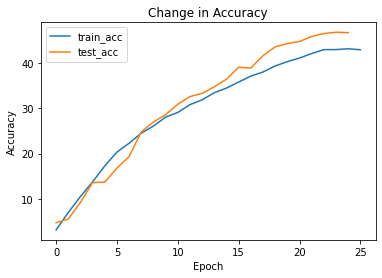

In [16]:
from evascheduler import draw_graph
draw_graph()


In [0]:
from evascheduler import get_misclassified
misclassified = get_misclassified()

In [18]:
import utils
from utils import plot_images
plot_images(misclassified,classes,"misclassified.png")

NameError: ignored

In [0]:
model_save_name = 'models11.pt'
PATH = F"/content/drive/My Drive/EVA/S7/{model_save_name}" 
torch.save(model.state_dict(), PATH)

In [20]:
path = F"/content/drive/My Drive/EVA/S7/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>